# DS-GA 1011 Homework 1 - Part 3
## N-Gram Language Modeling

In [ ]:
import os
import json
import numpy as np
from collections import defaultdict

#### Utilities

In [ ]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

### Additive Smoothing

Fill in the ngram_prob method in the class below:

In [ ]:
class NGramAdditive(object):
    def __init__(self, n, delta, vsize):
        self.n = n
        self.delta = delta
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vsize = vsize
    
    def estimate(self, sequences):
        for sequence in sequences:
            padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
            for i in range(len(padded_sequence) - self.n+1):
                ngram = tuple(padded_sequence[i:i+self.n])
                prefix, word = ngram[:-1], ngram[-1]
                self.count[prefix][word] += 1
                self.total[prefix] += 1
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prefix, word = ngram[:-1], ngram[-1]
        prob = (self.count[prefix][word] + self.delta) / (self.total[prefix] + self.delta * self.vsize)
        return prob

In [ ]:
datasets, vocab = load_wikitext()

delta = 0.0005
for n in [2, 3, 4]:
    lm = NGramAdditive(n=n, delta=delta, vsize=len(vocab)+1)  # +1 is for <eos>
    lm.estimate(datasets['train'])

    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Train Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['train'])))
    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Valid Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['valid'])))

--2020-10-07 00:00:10--  https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.box.com (nyu.box.com)... 107.152.24.197
Connecting to nyu.box.com (nyu.box.com)|107.152.24.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2020-10-07 00:00:10--  https://nyu.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2020-10-07 00:00:10--  https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.app.box.com (nyu.app.box.com)... 107.152.24.201
Connecting to nyu.app.box.com (nyu.app.box.com)|107.152.24.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/

In [ ]:
datasets, vocab = load_wikitext()

delta = 0.005
for n in [2, 3, 4]:
    lm = NGramAdditive(n=n, delta=delta, vsize=len(vocab)+1)  # +1 is for <eos>
    lm.estimate(datasets['train'])

    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Train Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['train'])))
    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Valid Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['valid'])))

Vocab size: 33175
Baseline (Additive smoothing, n=2, delta=0.0050)) Train Perplexity: 138.787
Baseline (Additive smoothing, n=2, delta=0.0050)) Valid Perplexity: 475.942
Baseline (Additive smoothing, n=3, delta=0.0050)) Train Perplexity: 116.398
Baseline (Additive smoothing, n=3, delta=0.0050)) Valid Perplexity: 2875.057
Baseline (Additive smoothing, n=4, delta=0.0050)) Train Perplexity: 139.759
Baseline (Additive smoothing, n=4, delta=0.0050)) Valid Perplexity: 10697.654


Is 0.005 a good value for $\delta$? Compare the model's perplexity across several orders of magnitude of $\delta$ (e.g., 0.0005, 0.005, 0.05, 0.5, and 1).

In [ ]:
from tqdm import tqdm
from itertools import product

ns = [2, 3, 4]
deltas = np.array([0.0005, 0.005, 0.05, 0.5, 1])

lms = {}
combos = list(product(ns, deltas))
for n, d in tqdm(combos, total=len(combos)):
    lm = NGramAdditive(n=n, delta=d, vsize=len(vocab)+1)
    lm.estimate(datasets['train'])    
    lms[n, d] = lm

T = np.zeros((len(ns), len(deltas)))
V = np.zeros((len(ns), len(deltas)))

for i, n in tqdm(enumerate(ns), total=len(ns)):
    lm = lms[n, 0.0005]
    for j, delta in enumerate(deltas):
        lm.delta = delta
        
        T[i, j] = perplexity(lm, datasets['train'])
        V[i, j] = perplexity(lm, datasets['valid'])

100%|██████████| 3/3 [01:59<00:00, 39.96s/it]


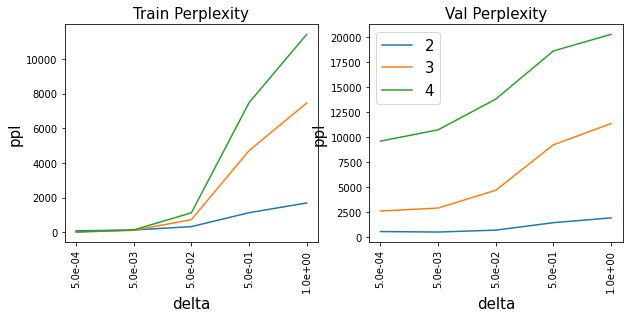

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for i in range(len(ns)):
    axs[0].plot(T[i])
    axs[1].plot(V[i])
    
axs[0].set_title("Train Perplexity", fontsize=15)
axs[1].set_title("Val Perplexity", fontsize=15)

axs[0].set_xticks(np.arange(len(deltas)))
axs[1].set_xticks(np.arange(len(deltas)))

axs[0].set_xticklabels(['{:.1e}'.format(x) for x in deltas], rotation=90)
axs[1].set_xticklabels(['{:.1e}'.format(x) for x in deltas], rotation=90)

axs[0].set_xlabel('delta', fontsize=15)
axs[1].set_xlabel('delta', fontsize=15)

axs[0].set_ylabel('ppl', fontsize=15)
axs[1].set_ylabel('ppl', fontsize=15)

plt.legend(ns, fontsize=15)

0.0005 seems to be the best value for $\delta$ when n = 3, 4, and 0.005 is the best value for $\delta$ when n = 2, with the smallest preplexity results for the valid set.

### Interpolation

Implement interpolation smoothing, and find optimal settings of the hyperparameters ($\lambda_1, \ldots, \lambda_n$), for each of $n \in \{2, 3, 4\}$. You can use grid search (i.e., systematically loop through a range of possible values). Show your results, including perplexity for all of the lambda values you have experimented with. Remember: hyperparameter optimization needs to be performed on the validation set -- do not touch the test set until the last section of this notebook!

In [ ]:
class NGramInterpolation(object):
    def __init__(self, n=2, lmd_0=0, lmd_1=0, lmd_2=0, lmd_3=0, vsize=0):
        self.n = n
        self.lmd_0 = lmd_0
        self.lmd_1 = lmd_1
        self.lmd_2 = lmd_2
        self.lmd_3 = lmd_3
        self.vsize = vsize
        self.all_count = []
        self.all_pre_total = []
        self.all_word_total = []
    
    def set_detla(self, new_delta):
        lmd_0 = new_delta[0] 
        lmd_1 = new_delta[1] 
        lmd_2 = new_delta[2]
        lmd_3 = new_delta[3]

    def estimate(self, sequences):
        for num in range(2,self.n+1):
            count = defaultdict(lambda: defaultdict(float))
            pre_total = defaultdict(float)
            word_total = defaultdict(float)
            for sequence in sequences:
                padded_sequence = ['<bos>']*(num-1) + sequence + ['<eos>']
                for i in range(len(padded_sequence) - num+1):
                    ngram = tuple(padded_sequence[i:i+num])
                    prefix, word = ngram[:-1], ngram[-1]
                    count[prefix][word] += 1
                    pre_total[prefix] += 1
                    word_total[word] += 1
            self.all_count.append(count)
            self.all_pre_total.append(pre_total)
            self.all_word_total.append(word_total)
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prefix, word = ngram[:-1], ngram[-1]
        uni_prob = self.all_word_total[0][word] / self.vsize
        prob = self.lmd_0 * uni_prob + (1 - self.lmd_0) * 1 / self.vsize
        
        if self.n >= 2:
            if self.all_pre_total[0][prefix] == 0:
                bi_prob = 1 / self.vsize
            else:
                bi_prob = self.all_count[0][prefix][word] / self.all_pre_total[0][prefix]
            prob = self.lmd_1 * bi_prob + (1 - self.lmd_1) * prob
            
            if self.n >= 3:
                if self.all_pre_total[1][prefix] == 0:
                    tri_prob = 1/self.vsize
                else:
                    tri_prob = self.all_count[1][prefix][word] / self.all_pre_total[1][prefix]
                prob = self.lmd_2 * tri_prob + (1 - self.lmd_2) * prob
                
                if self.n == 4:
                    if self.all_pre_total[2][prefix] == 0:
                        four_prob = 1/self.vsize
                    else:
                        four_prob = self.all_count[2][prefix][word] / self.all_pre_total[2][prefix]
                    prob = self.lmd_3 * four_prob + (1 - self.lmd_3) * prob
            
        return prob

In [ ]:
import itertools
d = [(a, 10-a) for a in range(1,10)]
d_2 = []
for i in d:
    d_2.append((i[0]/10, i[1]/10, 0, 0))

d = [(a, b-a, 10-b) for a, b in itertools.combinations(range(1, 10), 2)]
d_3 = []
for i in d:
    d_3.append((i[0]/10, i[1]/10, i[2]/10, 0))

d = [(a, b-a, c-b, 10-c) for a, b, c in itertools.combinations(range(1, 10), 3)]
d_4 = []
for i in d:
    d_4.append((i[0]/10, i[1]/10, i[2]/10, i[3]/10))

In [ ]:
for n in [2]:
    for i in tqdm(d_2):
        lm = NGramInterpolation(n=n, lmd_0=i[0], lmd_1=i[1], lmd_2=i[2], lmd_3=i[3], vsize=len(vocab)+1)  # +1 is for <eos>
        lm.estimate(datasets['train'])
        print("Baseline (Interpolation smoothing, n=%d, delta_1=%.4f, delta_2=%.4f, delta_3=%.4f, delta_4=%.4f)) Train Perplexity: %.3f" % (n, i[0], i[1], i[2], i[3], perplexity(lm, datasets['train'])))
        print("Baseline (Interpolation smoothing, n=%d, delta_1=%.4f, delta_2=%.4f, delta_3=%.4f, delta_4=%.4f)) Valid Perplexity: %.3f" % (n, i[0], i[1], i[2], i[3], perplexity(lm, datasets['valid'])))
        print("")


  0%|          | 0/10 [00:00<?, ?it/s]

Baseline (Interpolation smoothing, n=2, delta_1=0.1000, delta_2=0.9000, delta_3=0.0000, delta_4=0.0000)) Train Perplexity: 73.006



 10%|█         | 1/10 [00:08<01:19,  8.82s/it]

Baseline (Interpolation smoothing, n=2, delta_1=0.1000, delta_2=0.9000, delta_3=0.0000, delta_4=0.0000)) Valid Perplexity: 194.200

Baseline (Interpolation smoothing, n=2, delta_1=0.2000, delta_2=0.8000, delta_3=0.0000, delta_4=0.0000)) Train Perplexity: 60.399



 20%|██        | 2/10 [00:17<01:10,  8.78s/it]

Baseline (Interpolation smoothing, n=2, delta_1=0.2000, delta_2=0.8000, delta_3=0.0000, delta_4=0.0000)) Valid Perplexity: 119.467

Baseline (Interpolation smoothing, n=2, delta_1=0.3000, delta_2=0.7000, delta_3=0.0000, delta_4=0.0000)) Train Perplexity: 48.675



 30%|███       | 3/10 [00:26<01:01,  8.83s/it]

Baseline (Interpolation smoothing, n=2, delta_1=0.3000, delta_2=0.7000, delta_3=0.0000, delta_4=0.0000)) Valid Perplexity: 80.776

Baseline (Interpolation smoothing, n=2, delta_1=0.4000, delta_2=0.6000, delta_3=0.0000, delta_4=0.0000)) Train Perplexity: 39.445



 40%|████      | 4/10 [00:35<00:52,  8.77s/it]

Baseline (Interpolation smoothing, n=2, delta_1=0.4000, delta_2=0.6000, delta_3=0.0000, delta_4=0.0000)) Valid Perplexity: 57.870

Baseline (Interpolation smoothing, n=2, delta_1=0.5000, delta_2=0.5000, delta_3=0.0000, delta_4=0.0000)) Train Perplexity: 32.451



 50%|█████     | 5/10 [00:43<00:43,  8.78s/it]

Baseline (Interpolation smoothing, n=2, delta_1=0.5000, delta_2=0.5000, delta_3=0.0000, delta_4=0.0000)) Valid Perplexity: 43.289

Baseline (Interpolation smoothing, n=2, delta_1=0.6000, delta_2=0.4000, delta_3=0.0000, delta_4=0.0000)) Train Perplexity: 27.180



 60%|██████    | 6/10 [00:52<00:35,  8.79s/it]

Baseline (Interpolation smoothing, n=2, delta_1=0.6000, delta_2=0.4000, delta_3=0.0000, delta_4=0.0000)) Valid Perplexity: 33.509

Baseline (Interpolation smoothing, n=2, delta_1=0.7000, delta_2=0.3000, delta_3=0.0000, delta_4=0.0000)) Train Perplexity: 23.209



 70%|███████   | 7/10 [01:01<00:26,  8.81s/it]

Baseline (Interpolation smoothing, n=2, delta_1=0.7000, delta_2=0.3000, delta_3=0.0000, delta_4=0.0000)) Valid Perplexity: 26.681

Baseline (Interpolation smoothing, n=2, delta_1=0.8000, delta_2=0.2000, delta_3=0.0000, delta_4=0.0000)) Train Perplexity: 20.254



 80%|████████  | 8/10 [01:10<00:17,  8.78s/it]

Baseline (Interpolation smoothing, n=2, delta_1=0.8000, delta_2=0.2000, delta_3=0.0000, delta_4=0.0000)) Valid Perplexity: 21.770

Baseline (Interpolation smoothing, n=2, delta_1=0.9000, delta_2=0.1000, delta_3=0.0000, delta_4=0.0000)) Train Perplexity: 18.216



 90%|█████████ | 9/10 [01:18<00:08,  8.75s/it]

Baseline (Interpolation smoothing, n=2, delta_1=0.9000, delta_2=0.1000, delta_3=0.0000, delta_4=0.0000)) Valid Perplexity: 18.183

Baseline (Interpolation smoothing, n=2, delta_1=1.0000, delta_2=0.0000, delta_3=0.0000, delta_4=0.0000)) Train Perplexity: 18.595


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log2

100%|██████████| 10/10 [01:27<00:00,  8.78s/it]

Baseline (Interpolation smoothing, n=2, delta_1=1.0000, delta_2=0.0000, delta_3=0.0000, delta_4=0.0000)) Valid Perplexity: inf



In [ ]:
for n in [3]:
    for i in tqdm(d_3):
        lm = NGramInterpolation(n=n, lmd_0=i[0], lmd_1=i[1], lmd_2=i[2], lmd_3=i[3], vsize=len(vocab)+1)  # +1 is for <eos>
        lm.estimate(datasets['train'])
        print("Baseline (Interpolation smoothing, n=%d, delta_1=%.4f, delta_2=%.4f, delta_3=%.4f, delta_4=%.4f)) Train Perplexity: %.3f" % (n, i[0], i[1], i[2], i[3], perplexity(lm, datasets['train'])))
        print("Baseline (Interpolation smoothing, n=%d, delta_1=%.4f, delta_2=%.4f, delta_3=%.4f, delta_4=%.4f)) Valid Perplexity: %.3f" % (n, i[0], i[1], i[2], i[3], perplexity(lm, datasets['valid'])))
        print("")


  0%|          | 0/36 [00:00<?, ?it/s]

Baseline (Interpolation smoothing, n=3, delta_1=0.1000, delta_2=0.1000, delta_3=0.8000, delta_4=0.0000)) Train Perplexity: 9.249



  3%|▎         | 1/36 [00:14<08:41, 14.90s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.1000, delta_2=0.1000, delta_3=0.8000, delta_4=0.0000)) Valid Perplexity: 230.696

Baseline (Interpolation smoothing, n=3, delta_1=0.1000, delta_2=0.2000, delta_3=0.7000, delta_4=0.0000)) Train Perplexity: 10.196



  6%|▌         | 2/36 [00:32<08:55, 15.74s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.1000, delta_2=0.2000, delta_3=0.7000, delta_4=0.0000)) Valid Perplexity: 200.681

Baseline (Interpolation smoothing, n=3, delta_1=0.1000, delta_2=0.3000, delta_3=0.6000, delta_4=0.0000)) Train Perplexity: 11.499



  8%|▊         | 3/36 [00:47<08:32, 15.52s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.1000, delta_2=0.3000, delta_3=0.6000, delta_4=0.0000)) Valid Perplexity: 189.698

Baseline (Interpolation smoothing, n=3, delta_1=0.1000, delta_2=0.4000, delta_3=0.5000, delta_4=0.0000)) Train Perplexity: 13.346



 11%|█         | 4/36 [01:02<08:12, 15.38s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.1000, delta_2=0.4000, delta_3=0.5000, delta_4=0.0000)) Valid Perplexity: 190.059

Baseline (Interpolation smoothing, n=3, delta_1=0.1000, delta_2=0.5000, delta_3=0.4000, delta_4=0.0000)) Train Perplexity: 16.114



 14%|█▍        | 5/36 [01:17<07:53, 15.26s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.1000, delta_2=0.5000, delta_3=0.4000, delta_4=0.0000)) Valid Perplexity: 200.649

Baseline (Interpolation smoothing, n=3, delta_1=0.1000, delta_2=0.6000, delta_3=0.3000, delta_4=0.0000)) Train Perplexity: 20.656



 17%|█▋        | 6/36 [01:35<07:57, 15.90s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.1000, delta_2=0.6000, delta_3=0.3000, delta_4=0.0000)) Valid Perplexity: 224.528

Baseline (Interpolation smoothing, n=3, delta_1=0.1000, delta_2=0.7000, delta_3=0.2000, delta_4=0.0000)) Train Perplexity: 29.392



 19%|█▉        | 7/36 [01:49<07:30, 15.55s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.1000, delta_2=0.7000, delta_3=0.2000, delta_4=0.0000)) Valid Perplexity: 272.197

Baseline (Interpolation smoothing, n=3, delta_1=0.1000, delta_2=0.8000, delta_3=0.1000, delta_4=0.0000)) Train Perplexity: 53.069



 22%|██▏       | 8/36 [02:04<07:10, 15.39s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.1000, delta_2=0.8000, delta_3=0.1000, delta_4=0.0000)) Valid Perplexity: 381.367

Baseline (Interpolation smoothing, n=3, delta_1=0.2000, delta_2=0.1000, delta_3=0.7000, delta_4=0.0000)) Train Perplexity: 9.224



 25%|██▌       | 9/36 [02:19<06:52, 15.27s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.2000, delta_2=0.1000, delta_3=0.7000, delta_4=0.0000)) Valid Perplexity: 121.949

Baseline (Interpolation smoothing, n=3, delta_1=0.2000, delta_2=0.2000, delta_3=0.6000, delta_4=0.0000)) Train Perplexity: 10.167



 28%|██▊       | 10/36 [02:37<06:54, 15.96s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.2000, delta_2=0.2000, delta_3=0.6000, delta_4=0.0000)) Valid Perplexity: 112.651

Baseline (Interpolation smoothing, n=3, delta_1=0.2000, delta_2=0.3000, delta_3=0.5000, delta_4=0.0000)) Train Perplexity: 11.533



 31%|███       | 11/36 [02:52<06:31, 15.66s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.2000, delta_2=0.3000, delta_3=0.5000, delta_4=0.0000)) Valid Perplexity: 110.239

Baseline (Interpolation smoothing, n=3, delta_1=0.2000, delta_2=0.4000, delta_3=0.4000, delta_4=0.0000)) Train Perplexity: 13.583



 33%|███▎      | 12/36 [03:07<06:10, 15.42s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.2000, delta_2=0.4000, delta_3=0.4000, delta_4=0.0000)) Valid Perplexity: 113.301

Baseline (Interpolation smoothing, n=3, delta_1=0.2000, delta_2=0.5000, delta_3=0.3000, delta_4=0.0000)) Train Perplexity: 16.892



 36%|███▌      | 13/36 [03:22<05:51, 15.28s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.2000, delta_2=0.5000, delta_3=0.3000, delta_4=0.0000)) Valid Perplexity: 122.504

Baseline (Interpolation smoothing, n=3, delta_1=0.2000, delta_2=0.6000, delta_3=0.2000, delta_4=0.0000)) Train Perplexity: 23.006



 39%|███▉      | 14/36 [03:39<05:49, 15.91s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.2000, delta_2=0.6000, delta_3=0.2000, delta_4=0.0000)) Valid Perplexity: 141.139

Baseline (Interpolation smoothing, n=3, delta_1=0.2000, delta_2=0.7000, delta_3=0.1000, delta_4=0.0000)) Train Perplexity: 38.105



 42%|████▏     | 15/36 [03:54<05:26, 15.56s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.2000, delta_2=0.7000, delta_3=0.1000, delta_4=0.0000)) Valid Perplexity: 179.871

Baseline (Interpolation smoothing, n=3, delta_1=0.3000, delta_2=0.1000, delta_3=0.6000, delta_4=0.0000)) Train Perplexity: 9.088



 44%|████▍     | 16/36 [04:08<05:06, 15.32s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.3000, delta_2=0.1000, delta_3=0.6000, delta_4=0.0000)) Valid Perplexity: 78.315

Baseline (Interpolation smoothing, n=3, delta_1=0.3000, delta_2=0.2000, delta_3=0.5000, delta_4=0.0000)) Train Perplexity: 10.107



 47%|████▋     | 17/36 [04:23<04:48, 15.17s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.3000, delta_2=0.2000, delta_3=0.5000, delta_4=0.0000)) Valid Perplexity: 75.126

Baseline (Interpolation smoothing, n=3, delta_1=0.3000, delta_2=0.3000, delta_3=0.4000, delta_4=0.0000)) Train Perplexity: 11.647



 50%|█████     | 18/36 [04:41<04:46, 15.89s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.3000, delta_2=0.3000, delta_3=0.4000, delta_4=0.0000)) Valid Perplexity: 75.470

Baseline (Interpolation smoothing, n=3, delta_1=0.3000, delta_2=0.4000, delta_3=0.3000, delta_4=0.0000)) Train Perplexity: 14.102



 53%|█████▎    | 19/36 [04:56<04:24, 15.55s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.3000, delta_2=0.4000, delta_3=0.3000, delta_4=0.0000)) Valid Perplexity: 79.293

Baseline (Interpolation smoothing, n=3, delta_1=0.3000, delta_2=0.5000, delta_3=0.2000, delta_4=0.0000)) Train Perplexity: 18.491



 56%|█████▌    | 20/36 [05:10<04:05, 15.33s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.3000, delta_2=0.5000, delta_3=0.2000, delta_4=0.0000)) Valid Perplexity: 87.753

Baseline (Interpolation smoothing, n=3, delta_1=0.3000, delta_2=0.6000, delta_3=0.1000, delta_4=0.0000)) Train Perplexity: 28.606



 58%|█████▊    | 21/36 [05:25<03:47, 15.14s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.3000, delta_2=0.6000, delta_3=0.1000, delta_4=0.0000)) Valid Perplexity: 104.689

Baseline (Interpolation smoothing, n=3, delta_1=0.4000, delta_2=0.1000, delta_3=0.5000, delta_4=0.0000)) Train Perplexity: 8.946



 61%|██████    | 22/36 [05:40<03:29, 14.94s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.4000, delta_2=0.1000, delta_3=0.5000, delta_4=0.0000)) Valid Perplexity: 55.287

Baseline (Interpolation smoothing, n=3, delta_1=0.4000, delta_2=0.2000, delta_3=0.4000, delta_4=0.0000)) Train Perplexity: 10.114



 64%|██████▍   | 23/36 [05:57<03:23, 15.62s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.4000, delta_2=0.2000, delta_3=0.4000, delta_4=0.0000)) Valid Perplexity: 54.499

Baseline (Interpolation smoothing, n=3, delta_1=0.4000, delta_2=0.3000, delta_3=0.3000, delta_4=0.0000)) Train Perplexity: 11.966



 67%|██████▋   | 24/36 [06:11<03:03, 15.32s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.4000, delta_2=0.3000, delta_3=0.3000, delta_4=0.0000)) Valid Perplexity: 55.948

Baseline (Interpolation smoothing, n=3, delta_1=0.4000, delta_2=0.4000, delta_3=0.2000, delta_4=0.0000)) Train Perplexity: 15.203



 69%|██████▉   | 25/36 [06:26<02:45, 15.08s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.4000, delta_2=0.4000, delta_3=0.2000, delta_4=0.0000)) Valid Perplexity: 60.031

Baseline (Interpolation smoothing, n=3, delta_1=0.4000, delta_2=0.5000, delta_3=0.1000, delta_4=0.0000)) Train Perplexity: 22.307



 72%|███████▏  | 26/36 [06:41<02:29, 14.96s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.4000, delta_2=0.5000, delta_3=0.1000, delta_4=0.0000)) Valid Perplexity: 68.352

Baseline (Interpolation smoothing, n=3, delta_1=0.5000, delta_2=0.1000, delta_3=0.4000, delta_4=0.0000)) Train Perplexity: 8.875



 75%|███████▌  | 27/36 [06:58<02:20, 15.58s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.5000, delta_2=0.1000, delta_3=0.4000, delta_4=0.0000)) Valid Perplexity: 41.400

Baseline (Interpolation smoothing, n=3, delta_1=0.5000, delta_2=0.2000, delta_3=0.3000, delta_4=0.0000)) Train Perplexity: 10.295



 78%|███████▊  | 28/36 [07:12<02:02, 15.29s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.5000, delta_2=0.2000, delta_3=0.3000, delta_4=0.0000)) Valid Perplexity: 41.709

Baseline (Interpolation smoothing, n=3, delta_1=0.5000, delta_2=0.3000, delta_3=0.2000, delta_4=0.0000)) Train Perplexity: 12.740



 81%|████████  | 29/36 [07:27<01:46, 15.18s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.5000, delta_2=0.3000, delta_3=0.2000, delta_4=0.0000)) Valid Perplexity: 43.686

Baseline (Interpolation smoothing, n=3, delta_1=0.5000, delta_2=0.4000, delta_3=0.1000, delta_4=0.0000)) Train Perplexity: 17.929



 83%|████████▎ | 30/36 [07:42<01:29, 15.00s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.5000, delta_2=0.4000, delta_3=0.1000, delta_4=0.0000)) Valid Perplexity: 48.066

Baseline (Interpolation smoothing, n=3, delta_1=0.6000, delta_2=0.1000, delta_3=0.3000, delta_4=0.0000)) Train Perplexity: 8.962



 86%|████████▌ | 31/36 [08:00<01:19, 15.82s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.6000, delta_2=0.1000, delta_3=0.3000, delta_4=0.0000)) Valid Perplexity: 32.333

Baseline (Interpolation smoothing, n=3, delta_1=0.6000, delta_2=0.2000, delta_3=0.2000, delta_4=0.0000)) Train Perplexity: 10.848



 89%|████████▉ | 32/36 [08:14<01:01, 15.45s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.6000, delta_2=0.2000, delta_3=0.2000, delta_4=0.0000)) Valid Perplexity: 33.221

Baseline (Interpolation smoothing, n=3, delta_1=0.6000, delta_2=0.3000, delta_3=0.1000, delta_4=0.0000)) Train Perplexity: 14.760



 92%|█████████▏| 33/36 [08:29<00:45, 15.24s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.6000, delta_2=0.3000, delta_3=0.1000, delta_4=0.0000)) Valid Perplexity: 35.611

Baseline (Interpolation smoothing, n=3, delta_1=0.7000, delta_2=0.1000, delta_3=0.2000, delta_4=0.0000)) Train Perplexity: 9.363



 94%|█████████▍| 34/36 [08:44<00:30, 15.09s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.7000, delta_2=0.1000, delta_3=0.2000, delta_4=0.0000)) Valid Perplexity: 26.114

Baseline (Interpolation smoothing, n=3, delta_1=0.7000, delta_2=0.2000, delta_3=0.1000, delta_4=0.0000)) Train Perplexity: 12.387



 97%|█████████▋| 35/36 [09:01<00:15, 15.79s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.7000, delta_2=0.2000, delta_3=0.1000, delta_4=0.0000)) Valid Perplexity: 27.426

Baseline (Interpolation smoothing, n=3, delta_1=0.8000, delta_2=0.1000, delta_3=0.1000, delta_4=0.0000)) Train Perplexity: 10.562



100%|██████████| 36/36 [09:15<00:00, 15.44s/it]

Baseline (Interpolation smoothing, n=3, delta_1=0.8000, delta_2=0.1000, delta_3=0.1000, delta_4=0.0000)) Valid Perplexity: 21.764



In [ ]:
for n in [4]:
    for i in tqdm(d_4):
        lm = NGramInterpolation(n=n, lmd_0=i[0], lmd_1=i[1], lmd_2=i[2], lmd_3=i[3], vsize=len(vocab)+1)  # +1 is for <eos>
        lm.estimate(datasets['train'])
        print("Baseline (Interpolation smoothing, n=%d, delta_1=%.4f, delta_2=%.4f, delta_3=%.4f, delta_4=%.4f)) Train Perplexity: %.3f" % (n, i[0], i[1], i[2], i[3], perplexity(lm, datasets['train'])))
        print("Baseline (Interpolation smoothing, n=%d, delta_1=%.4f, delta_2=%.4f, delta_3=%.4f, delta_4=%.4f)) Valid Perplexity: %.3f" % (n, i[0], i[1], i[2], i[3], perplexity(lm, datasets['valid'])))
        print("")





  0%|          | 0/84 [00:00<?, ?it/s]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.1000, delta_3=0.1000, delta_4=0.7000)) Train Perplexity: 3.262






  1%|          | 1/84 [00:24<34:26, 24.90s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.1000, delta_3=0.1000, delta_4=0.7000)) Valid Perplexity: 309.702

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.1000, delta_3=0.2000, delta_4=0.6000)) Train Perplexity: 3.734






  2%|▏         | 2/84 [00:45<32:22, 23.69s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.1000, delta_3=0.2000, delta_4=0.6000)) Valid Perplexity: 277.921

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.1000, delta_3=0.3000, delta_4=0.5000)) Train Perplexity: 4.392






  4%|▎         | 3/84 [01:09<32:06, 23.78s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.1000, delta_3=0.3000, delta_4=0.5000)) Valid Perplexity: 265.451

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.1000, delta_3=0.4000, delta_4=0.4000)) Train Perplexity: 5.369






  5%|▍         | 4/84 [01:30<30:28, 22.86s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.1000, delta_3=0.4000, delta_4=0.4000)) Valid Perplexity: 266.726

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.1000, delta_3=0.5000, delta_4=0.3000)) Train Perplexity: 6.965






  6%|▌         | 5/84 [01:54<30:33, 23.21s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.1000, delta_3=0.5000, delta_4=0.3000)) Valid Perplexity: 281.693

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.1000, delta_3=0.6000, delta_4=0.2000)) Train Perplexity: 10.033






  7%|▋         | 6/84 [02:15<29:13, 22.48s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.1000, delta_3=0.6000, delta_4=0.2000)) Valid Perplexity: 315.623

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.1000, delta_3=0.7000, delta_4=0.1000)) Train Perplexity: 18.416






  8%|▊         | 7/84 [02:39<29:25, 22.92s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.1000, delta_3=0.7000, delta_4=0.1000)) Valid Perplexity: 386.538

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.2000, delta_3=0.1000, delta_4=0.6000)) Train Perplexity: 3.734






 10%|▉         | 8/84 [03:03<29:26, 23.24s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.2000, delta_3=0.1000, delta_4=0.6000)) Valid Perplexity: 277.921

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.2000, delta_3=0.2000, delta_4=0.5000)) Train Perplexity: 4.387






 11%|█         | 9/84 [03:24<28:12, 22.57s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.2000, delta_3=0.2000, delta_4=0.5000)) Valid Perplexity: 262.383

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.2000, delta_3=0.3000, delta_4=0.4000)) Train Perplexity: 5.351






 12%|█▏        | 10/84 [03:48<28:19, 22.97s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.2000, delta_3=0.3000, delta_4=0.4000)) Valid Perplexity: 259.615

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.2000, delta_3=0.4000, delta_4=0.3000)) Train Perplexity: 6.916






 13%|█▎        | 11/84 [04:08<27:04, 22.25s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.2000, delta_3=0.4000, delta_4=0.3000)) Valid Perplexity: 268.446

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.2000, delta_3=0.5000, delta_4=0.2000)) Train Perplexity: 9.892






 14%|█▍        | 12/84 [04:32<27:16, 22.73s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.2000, delta_3=0.5000, delta_4=0.2000)) Valid Perplexity: 291.674

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.2000, delta_3=0.6000, delta_4=0.1000)) Train Perplexity: 17.851






 15%|█▌        | 13/84 [04:56<27:18, 23.08s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.2000, delta_3=0.6000, delta_4=0.1000)) Valid Perplexity: 340.020

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.3000, delta_3=0.1000, delta_4=0.5000)) Train Perplexity: 4.392






 17%|█▋        | 14/84 [05:17<26:08, 22.41s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.3000, delta_3=0.1000, delta_4=0.5000)) Valid Perplexity: 265.451

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.3000, delta_3=0.2000, delta_4=0.4000)) Train Perplexity: 5.351






 18%|█▊        | 15/84 [05:41<26:17, 22.86s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.3000, delta_3=0.2000, delta_4=0.4000)) Valid Perplexity: 259.615

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.3000, delta_3=0.3000, delta_4=0.3000)) Train Perplexity: 6.900






 19%|█▉        | 16/84 [06:05<26:23, 23.29s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.3000, delta_3=0.3000, delta_4=0.3000)) Valid Perplexity: 264.327

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.3000, delta_3=0.4000, delta_4=0.2000)) Train Perplexity: 9.824






 20%|██        | 17/84 [06:26<25:10, 22.55s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.3000, delta_3=0.4000, delta_4=0.2000)) Valid Perplexity: 281.117

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.3000, delta_3=0.5000, delta_4=0.1000)) Train Perplexity: 17.539






 21%|██▏       | 18/84 [06:50<25:23, 23.08s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.3000, delta_3=0.5000, delta_4=0.1000)) Valid Perplexity: 317.450

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.4000, delta_3=0.1000, delta_4=0.4000)) Train Perplexity: 5.369






 23%|██▎       | 19/84 [07:11<24:10, 22.32s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.4000, delta_3=0.1000, delta_4=0.4000)) Valid Perplexity: 266.726

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.4000, delta_3=0.2000, delta_4=0.3000)) Train Perplexity: 6.916






 24%|██▍       | 20/84 [07:35<24:26, 22.91s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.4000, delta_3=0.2000, delta_4=0.3000)) Valid Perplexity: 268.446

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.4000, delta_3=0.3000, delta_4=0.2000)) Train Perplexity: 9.824






 25%|██▌       | 21/84 [07:56<23:25, 22.31s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.4000, delta_3=0.3000, delta_4=0.2000)) Valid Perplexity: 281.117

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.4000, delta_3=0.4000, delta_4=0.1000)) Train Perplexity: 17.439






 26%|██▌       | 22/84 [08:20<23:38, 22.88s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.4000, delta_3=0.4000, delta_4=0.1000)) Valid Perplexity: 310.623

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.5000, delta_3=0.1000, delta_4=0.3000)) Train Perplexity: 6.965






 27%|██▋       | 23/84 [08:44<23:38, 23.25s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.5000, delta_3=0.1000, delta_4=0.3000)) Valid Perplexity: 281.693

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.5000, delta_3=0.2000, delta_4=0.2000)) Train Perplexity: 9.892






 29%|██▊       | 24/84 [09:05<22:25, 22.43s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.5000, delta_3=0.2000, delta_4=0.2000)) Valid Perplexity: 291.674

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.5000, delta_3=0.3000, delta_4=0.1000)) Train Perplexity: 17.539






 30%|██▉       | 25/84 [09:29<22:31, 22.91s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.5000, delta_3=0.3000, delta_4=0.1000)) Valid Perplexity: 317.450

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.6000, delta_3=0.1000, delta_4=0.2000)) Train Perplexity: 10.033






 31%|███       | 26/84 [09:49<21:29, 22.24s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.6000, delta_3=0.1000, delta_4=0.2000)) Valid Perplexity: 315.623

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.6000, delta_3=0.2000, delta_4=0.1000)) Train Perplexity: 17.851






 32%|███▏      | 27/84 [10:13<21:30, 22.65s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.6000, delta_3=0.2000, delta_4=0.1000)) Valid Perplexity: 340.020

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.7000, delta_3=0.1000, delta_4=0.1000)) Train Perplexity: 18.416






 33%|███▎      | 28/84 [10:37<21:34, 23.11s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.1000, delta_2=0.7000, delta_3=0.1000, delta_4=0.1000)) Valid Perplexity: 386.538

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.1000, delta_3=0.1000, delta_4=0.6000)) Train Perplexity: 3.486






 35%|███▍      | 29/84 [10:58<20:28, 22.34s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.1000, delta_3=0.1000, delta_4=0.6000)) Valid Perplexity: 150.024

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.1000, delta_3=0.2000, delta_4=0.5000)) Train Perplexity: 4.036






 36%|███▌      | 30/84 [11:22<20:34, 22.87s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.1000, delta_3=0.2000, delta_4=0.5000)) Valid Perplexity: 140.635

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.1000, delta_3=0.3000, delta_4=0.4000)) Train Perplexity: 4.848






 37%|███▋      | 31/84 [11:42<19:34, 22.17s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.1000, delta_3=0.3000, delta_4=0.4000)) Valid Perplexity: 138.398

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.1000, delta_3=0.4000, delta_4=0.3000)) Train Perplexity: 6.150






 38%|███▊      | 32/84 [12:06<19:41, 22.73s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.1000, delta_3=0.4000, delta_4=0.3000)) Valid Perplexity: 142.459

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.1000, delta_3=0.5000, delta_4=0.2000)) Train Perplexity: 8.573






 39%|███▉      | 33/84 [12:30<19:37, 23.08s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.1000, delta_3=0.5000, delta_4=0.2000)) Valid Perplexity: 154.056

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.1000, delta_3=0.6000, delta_4=0.1000)) Train Perplexity: 14.752






 40%|████      | 34/84 [12:51<18:39, 22.39s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.1000, delta_3=0.6000, delta_4=0.1000)) Valid Perplexity: 178.114

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.2000, delta_3=0.1000, delta_4=0.5000)) Train Perplexity: 4.036






 42%|████▏     | 35/84 [13:16<18:48, 23.02s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.2000, delta_3=0.1000, delta_4=0.5000)) Valid Perplexity: 140.635

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.2000, delta_3=0.2000, delta_4=0.4000)) Train Perplexity: 4.836






 43%|████▎     | 36/84 [13:36<17:53, 22.37s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.2000, delta_3=0.2000, delta_4=0.4000)) Valid Perplexity: 136.651

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.2000, delta_3=0.3000, delta_4=0.3000)) Train Perplexity: 6.109






 44%|████▍     | 37/84 [14:00<17:54, 22.86s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.2000, delta_3=0.3000, delta_4=0.3000)) Valid Perplexity: 138.304

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.2000, delta_3=0.4000, delta_4=0.2000)) Train Perplexity: 8.452






 45%|████▌     | 38/84 [14:21<17:00, 22.18s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.2000, delta_3=0.4000, delta_4=0.2000)) Valid Perplexity: 146.098

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.2000, delta_3=0.5000, delta_4=0.1000)) Train Perplexity: 14.315






 46%|████▋     | 39/84 [14:45<17:01, 22.69s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.2000, delta_3=0.5000, delta_4=0.1000)) Valid Perplexity: 163.127

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.3000, delta_3=0.1000, delta_4=0.4000)) Train Perplexity: 4.848






 48%|████▊     | 40/84 [15:09<16:55, 23.08s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.3000, delta_3=0.1000, delta_4=0.4000)) Valid Perplexity: 138.398

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.3000, delta_3=0.2000, delta_4=0.3000)) Train Perplexity: 6.109






 49%|████▉     | 41/84 [15:30<16:05, 22.45s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.3000, delta_3=0.2000, delta_4=0.3000)) Valid Perplexity: 138.304

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.3000, delta_3=0.3000, delta_4=0.2000)) Train Perplexity: 8.413






 50%|█████     | 42/84 [15:54<16:08, 23.06s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.3000, delta_3=0.3000, delta_4=0.2000)) Valid Perplexity: 143.634

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.3000, delta_3=0.4000, delta_4=0.1000)) Train Perplexity: 14.111






 51%|█████     | 43/84 [16:15<15:19, 22.42s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.3000, delta_3=0.4000, delta_4=0.1000)) Valid Perplexity: 156.577

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.4000, delta_3=0.1000, delta_4=0.3000)) Train Perplexity: 6.150






 52%|█████▏    | 44/84 [16:40<15:19, 22.98s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.4000, delta_3=0.1000, delta_4=0.3000)) Valid Perplexity: 142.459

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.4000, delta_3=0.2000, delta_4=0.2000)) Train Perplexity: 8.452






 54%|█████▎    | 45/84 [17:04<15:11, 23.36s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.4000, delta_3=0.2000, delta_4=0.2000)) Valid Perplexity: 146.098

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.4000, delta_3=0.3000, delta_4=0.1000)) Train Perplexity: 14.111






 55%|█████▍    | 46/84 [17:25<14:21, 22.66s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.4000, delta_3=0.3000, delta_4=0.1000)) Valid Perplexity: 156.577

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.5000, delta_3=0.1000, delta_4=0.2000)) Train Perplexity: 8.573






 56%|█████▌    | 47/84 [17:49<14:17, 23.18s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.5000, delta_3=0.1000, delta_4=0.2000)) Valid Perplexity: 154.056

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.5000, delta_3=0.2000, delta_4=0.1000)) Train Perplexity: 14.315






 57%|█████▋    | 48/84 [18:10<13:32, 22.58s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.5000, delta_3=0.2000, delta_4=0.1000)) Valid Perplexity: 163.127

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.6000, delta_3=0.1000, delta_4=0.1000)) Train Perplexity: 14.752






 58%|█████▊    | 49/84 [18:35<13:27, 23.09s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.2000, delta_2=0.6000, delta_3=0.1000, delta_4=0.1000)) Valid Perplexity: 178.114

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.1000, delta_3=0.1000, delta_4=0.5000)) Train Perplexity: 3.723






 60%|█████▉    | 50/84 [18:56<12:43, 22.47s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.1000, delta_3=0.1000, delta_4=0.5000)) Valid Perplexity: 91.747

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.1000, delta_3=0.2000, delta_4=0.4000)) Train Perplexity: 4.398






 61%|██████    | 51/84 [19:20<12:38, 22.98s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.1000, delta_3=0.2000, delta_4=0.4000)) Valid Perplexity: 88.732

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.1000, delta_3=0.3000, delta_4=0.3000)) Train Perplexity: 5.468






 62%|██████▏   | 52/84 [19:44<12:27, 23.35s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.1000, delta_3=0.3000, delta_4=0.3000)) Valid Perplexity: 89.414

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.1000, delta_3=0.4000, delta_4=0.2000)) Train Perplexity: 7.407






 63%|██████▎   | 53/84 [20:05<11:41, 22.64s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.1000, delta_3=0.4000, delta_4=0.2000)) Valid Perplexity: 93.999

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.1000, delta_3=0.5000, delta_4=0.1000)) Train Perplexity: 12.105






 64%|██████▍   | 54/84 [20:29<11:34, 23.14s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.1000, delta_3=0.5000, delta_4=0.1000)) Valid Perplexity: 104.211

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.2000, delta_3=0.1000, delta_4=0.4000)) Train Perplexity: 4.398






 65%|██████▌   | 55/84 [20:50<10:51, 22.45s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.2000, delta_3=0.1000, delta_4=0.4000)) Valid Perplexity: 88.732

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.2000, delta_3=0.2000, delta_4=0.3000)) Train Perplexity: 5.447






 67%|██████▋   | 56/84 [21:15<10:45, 23.06s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.2000, delta_3=0.2000, delta_4=0.3000)) Valid Perplexity: 88.222

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.2000, delta_3=0.3000, delta_4=0.2000)) Train Perplexity: 7.331






 68%|██████▊   | 57/84 [21:40<10:37, 23.61s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.2000, delta_3=0.3000, delta_4=0.2000)) Valid Perplexity: 91.099

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.2000, delta_3=0.4000, delta_4=0.1000)) Train Perplexity: 11.832






 69%|██████▉   | 58/84 [22:01<09:52, 22.78s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.2000, delta_3=0.4000, delta_4=0.1000)) Valid Perplexity: 98.485

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.3000, delta_3=0.1000, delta_4=0.3000)) Train Perplexity: 5.468






 70%|███████   | 59/84 [22:25<09:41, 23.24s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.3000, delta_3=0.1000, delta_4=0.3000)) Valid Perplexity: 89.414

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.3000, delta_3=0.2000, delta_4=0.2000)) Train Perplexity: 7.331






 71%|███████▏  | 60/84 [22:50<09:30, 23.75s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.3000, delta_3=0.2000, delta_4=0.2000)) Valid Perplexity: 91.099

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.3000, delta_3=0.3000, delta_4=0.1000)) Train Perplexity: 11.745






 73%|███████▎  | 61/84 [23:11<08:48, 22.98s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.3000, delta_3=0.3000, delta_4=0.1000)) Valid Perplexity: 96.718

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.4000, delta_3=0.1000, delta_4=0.2000)) Train Perplexity: 7.407






 74%|███████▍  | 62/84 [23:35<08:35, 23.44s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.4000, delta_3=0.1000, delta_4=0.2000)) Valid Perplexity: 93.999

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.4000, delta_3=0.2000, delta_4=0.1000)) Train Perplexity: 11.832






 75%|███████▌  | 63/84 [23:57<07:58, 22.78s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.4000, delta_3=0.2000, delta_4=0.1000)) Valid Perplexity: 98.485

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.5000, delta_3=0.1000, delta_4=0.1000)) Train Perplexity: 12.105






 76%|███████▌  | 64/84 [24:21<07:46, 23.32s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.3000, delta_2=0.5000, delta_3=0.1000, delta_4=0.1000)) Valid Perplexity: 104.211

Baseline (Interpolation smoothing, n=4, delta_1=0.4000, delta_2=0.1000, delta_3=0.1000, delta_4=0.4000)) Train Perplexity: 4.009






 77%|███████▋  | 65/84 [24:43<07:12, 22.76s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.4000, delta_2=0.1000, delta_3=0.1000, delta_4=0.4000)) Valid Perplexity: 62.722

Baseline (Interpolation smoothing, n=4, delta_1=0.4000, delta_2=0.1000, delta_3=0.2000, delta_4=0.3000)) Train Perplexity: 4.895






 79%|███████▊  | 66/84 [25:07<07:00, 23.36s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.4000, delta_2=0.1000, delta_3=0.2000, delta_4=0.3000)) Valid Perplexity: 62.124

Baseline (Interpolation smoothing, n=4, delta_1=0.4000, delta_2=0.1000, delta_3=0.3000, delta_4=0.2000)) Train Perplexity: 6.471






 80%|███████▉  | 67/84 [25:33<06:45, 23.87s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.4000, delta_2=0.1000, delta_3=0.3000, delta_4=0.2000)) Valid Perplexity: 63.884

Baseline (Interpolation smoothing, n=4, delta_1=0.4000, delta_2=0.1000, delta_3=0.4000, delta_4=0.1000)) Train Perplexity: 10.149






 81%|████████  | 68/84 [25:55<06:12, 23.29s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.4000, delta_2=0.1000, delta_3=0.4000, delta_4=0.1000)) Valid Perplexity: 68.675

Baseline (Interpolation smoothing, n=4, delta_1=0.4000, delta_2=0.2000, delta_3=0.1000, delta_4=0.3000)) Train Perplexity: 4.895






 82%|████████▏ | 69/84 [26:21<06:01, 24.11s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.4000, delta_2=0.2000, delta_3=0.1000, delta_4=0.3000)) Valid Perplexity: 62.124

Baseline (Interpolation smoothing, n=4, delta_1=0.4000, delta_2=0.2000, delta_3=0.2000, delta_4=0.2000)) Train Perplexity: 6.437






 83%|████████▎ | 70/84 [26:43<05:28, 23.49s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.4000, delta_2=0.2000, delta_3=0.2000, delta_4=0.2000)) Valid Perplexity: 62.998

Baseline (Interpolation smoothing, n=4, delta_1=0.4000, delta_2=0.2000, delta_3=0.3000, delta_4=0.1000)) Train Perplexity: 10.002






 85%|████████▍ | 71/84 [27:07<05:09, 23.84s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.4000, delta_2=0.2000, delta_3=0.3000, delta_4=0.1000)) Valid Perplexity: 66.461

Baseline (Interpolation smoothing, n=4, delta_1=0.4000, delta_2=0.3000, delta_3=0.1000, delta_4=0.2000)) Train Perplexity: 6.471






 86%|████████▌ | 72/84 [27:32<04:50, 24.20s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.4000, delta_2=0.3000, delta_3=0.1000, delta_4=0.2000)) Valid Perplexity: 63.884

Baseline (Interpolation smoothing, n=4, delta_1=0.4000, delta_2=0.3000, delta_3=0.2000, delta_4=0.1000)) Train Perplexity: 10.002






 87%|████████▋ | 73/84 [27:54<04:18, 23.50s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.4000, delta_2=0.3000, delta_3=0.2000, delta_4=0.1000)) Valid Perplexity: 66.461

Baseline (Interpolation smoothing, n=4, delta_1=0.4000, delta_2=0.4000, delta_3=0.1000, delta_4=0.1000)) Train Perplexity: 10.149






 88%|████████▊ | 74/84 [28:19<04:00, 24.05s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.4000, delta_2=0.4000, delta_3=0.1000, delta_4=0.1000)) Valid Perplexity: 68.675

Baseline (Interpolation smoothing, n=4, delta_1=0.5000, delta_2=0.1000, delta_3=0.1000, delta_4=0.3000)) Train Perplexity: 4.412






 89%|████████▉ | 75/84 [28:45<03:40, 24.45s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.5000, delta_2=0.1000, delta_3=0.1000, delta_4=0.3000)) Valid Perplexity: 45.920

Baseline (Interpolation smoothing, n=4, delta_1=0.5000, delta_2=0.1000, delta_3=0.2000, delta_4=0.2000)) Train Perplexity: 5.711






 90%|█████████ | 76/84 [29:07<03:09, 23.67s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.5000, delta_2=0.1000, delta_3=0.2000, delta_4=0.2000)) Valid Perplexity: 46.403

Baseline (Interpolation smoothing, n=4, delta_1=0.5000, delta_2=0.1000, delta_3=0.3000, delta_4=0.1000)) Train Perplexity: 8.665






 92%|█████████▏| 77/84 [29:32<02:49, 24.27s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.5000, delta_2=0.1000, delta_3=0.3000, delta_4=0.1000)) Valid Perplexity: 48.732

Baseline (Interpolation smoothing, n=4, delta_1=0.5000, delta_2=0.2000, delta_3=0.1000, delta_4=0.2000)) Train Perplexity: 5.711






 93%|█████████▎| 78/84 [29:54<02:21, 23.60s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.5000, delta_2=0.2000, delta_3=0.1000, delta_4=0.2000)) Valid Perplexity: 46.403

Baseline (Interpolation smoothing, n=4, delta_1=0.5000, delta_2=0.2000, delta_3=0.2000, delta_4=0.1000)) Train Perplexity: 8.605






 94%|█████████▍| 79/84 [30:20<02:01, 24.26s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.5000, delta_2=0.2000, delta_3=0.2000, delta_4=0.1000)) Valid Perplexity: 48.032

Baseline (Interpolation smoothing, n=4, delta_1=0.5000, delta_2=0.3000, delta_3=0.1000, delta_4=0.1000)) Train Perplexity: 8.665






 95%|█████████▌| 80/84 [30:43<01:34, 23.70s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.5000, delta_2=0.3000, delta_3=0.1000, delta_4=0.1000)) Valid Perplexity: 48.732

Baseline (Interpolation smoothing, n=4, delta_1=0.6000, delta_2=0.1000, delta_3=0.1000, delta_4=0.2000)) Train Perplexity: 5.087






 96%|█████████▋| 81/84 [31:08<01:12, 24.19s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.6000, delta_2=0.1000, delta_3=0.1000, delta_4=0.2000)) Valid Perplexity: 35.291

Baseline (Interpolation smoothing, n=4, delta_1=0.6000, delta_2=0.1000, delta_3=0.2000, delta_4=0.1000)) Train Perplexity: 7.508






 98%|█████████▊| 82/84 [31:34<00:49, 24.67s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.6000, delta_2=0.1000, delta_3=0.2000, delta_4=0.1000)) Valid Perplexity: 36.393

Baseline (Interpolation smoothing, n=4, delta_1=0.6000, delta_2=0.2000, delta_3=0.1000, delta_4=0.1000)) Train Perplexity: 7.508






 99%|█████████▉| 83/84 [31:56<00:24, 24.09s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.6000, delta_2=0.2000, delta_3=0.1000, delta_4=0.1000)) Valid Perplexity: 36.393

Baseline (Interpolation smoothing, n=4, delta_1=0.7000, delta_2=0.1000, delta_3=0.1000, delta_4=0.1000)) Train Perplexity: 6.587






100%|██████████| 84/84 [32:22<00:00, 23.12s/it]

Baseline (Interpolation smoothing, n=4, delta_1=0.7000, delta_2=0.1000, delta_3=0.1000, delta_4=0.1000)) Valid Perplexity: 28.220



Now compare the performance of the two smoothing methods on the test set. Use the best hyperparameters you found for each.

When n = 2, 

1) Additive Smoothing

In [ ]:
delta = 0.005

lm = NGramAdditive(n=2, delta=delta, vsize=len(vocab)+1)  # +1 is for <eos>
lm.estimate(datasets['train'])

print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Test Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['test'])))

Baseline (Additive smoothing, n=4, delta=0.0050)) Test Perplexity: 447.054


2) Interpolation Smoothing

In [ ]:
delta = (0.9000, 0.1000, 0, 0)

lm = NGramInterpolation(n=2, lmd_0=delta[0], lmd_1=delta[1], lmd_2=delta[2], lmd_3=delta[3], vsize=len(vocab)+1)  # +1 is for <eos>
lm.estimate(datasets['train'])

print("Baseline (Interpolation smoothing, n=%d, delta_1=%.4f, delta_2=%.4f, delta_3=%.4f, delta_4=%.4f)) Valid Perplexity: %.3f" % (n, delta[0], delta[1], delta[2], delta[3], perplexity(lm, datasets['test'])))

Baseline (Interpolation smoothing, n=4, delta_1=0.9000, delta_2=0.1000, delta_3=0.0000, delta_4=0.0000)) Valid Perplexity: 17.478


When n = 3,

1) Additive Smoothing

In [ ]:
delta = 0.0005

lm = NGramAdditive(n=3, delta=delta, vsize=len(vocab)+1)  # +1 is for <eos>
lm.estimate(datasets['train'])

print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Test Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['test'])))

Baseline (Additive smoothing, n=4, delta=0.0005)) Test Perplexity: 2417.329


2) Interpolation Smoothing

In [ ]:
delta = (0.8000, 0.1000, 0.1000, 0)

lm = NGramInterpolation(n=3, lmd_0=delta[0], lmd_1=delta[1], lmd_2=delta[2], lmd_3=delta[3], vsize=len(vocab)+1)  # +1 is for <eos>
lm.estimate(datasets['train'])

print("Baseline (Interpolation smoothing, n=%d, delta_1=%.4f, delta_2=%.4f, delta_3=%.4f, delta_4=%.4f)) Valid Perplexity: %.3f" % (n, delta[0], delta[1], delta[2], delta[3], perplexity(lm, datasets['test'])))

Baseline (Interpolation smoothing, n=4, delta_1=0.8000, delta_2=0.1000, delta_3=0.1000, delta_4=0.0000)) Valid Perplexity: 20.954


When n = 4,

1) Additive Smoothing

In [ ]:
delta = 0.0005

lm = NGramAdditive(n=4, delta=delta, vsize=len(vocab)+1)  # +1 is for <eos>
lm.estimate(datasets['train'])

print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Test Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['test'])))

Baseline (Additive smoothing, n=4, delta=0.0005)) Test Perplexity: 9209.615


2) Interpolation Smoothing

In [ ]:
delta = (0.7000, 0.1000, 0.1000, .1000)

lm = NGramInterpolation(n=3, lmd_0=delta[0], lmd_1=delta[1], lmd_2=delta[2], lmd_3=delta[3], vsize=len(vocab)+1)  # +1 is for <eos>
lm.estimate(datasets['train'])

print("Baseline (Interpolation smoothing, n=%d, delta_1=%.4f, delta_2=%.4f, delta_3=%.4f, delta_4=%.4f)) Valid Perplexity: %.3f" % (n, delta[0], delta[1], delta[2], delta[3], perplexity(lm, datasets['test'])))

Baseline (Interpolation smoothing, n=4, delta_1=0.7000, delta_2=0.1000, delta_3=0.1000, delta_4=0.1000)) Valid Perplexity: 23.700
